In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
# import required packages
import pandas as pd
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split

# models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# metrics
import time

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.axes_style('white')
from mpl_toolkits.mplot3d import Axes3D

In [44]:
# load the data into a dataframe
df = pd.read_csv('../data/water_potability.csv')

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [45]:
# shape: rows, columns
display(df.shape)

# info of the dataset
df.info()

(3276, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [46]:
# count duplicate datapoints
df.duplicated().sum()

0

In [47]:
# count null values(NaN) for each column
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Feature Importance Analysis

In [48]:
# drop all null value rows for feature selection
# shape before dropping rows with null values
display(df.shape)

df_no_null_features = df.dropna(axis=0)

# shape after dropping rows with null values
display(df_no_null_features.shape)

# separate independent and dependent features
x = df_no_null_features.drop('Potability', axis=1)
y = df_no_null_features['Potability']

(3276, 10)

(2011, 10)

In [49]:
# feature importance analysis using XGBoost
# instantiate an XGBoost model
model = XGBClassifier(n_estimators=100)

# training start
print('training XGBoost...')
start_time = time.time()

# train the model
model.fit(x, y)

# training end
end_time = time.time()
print('training completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training XGBoost...
training completed: 1.16 seconds


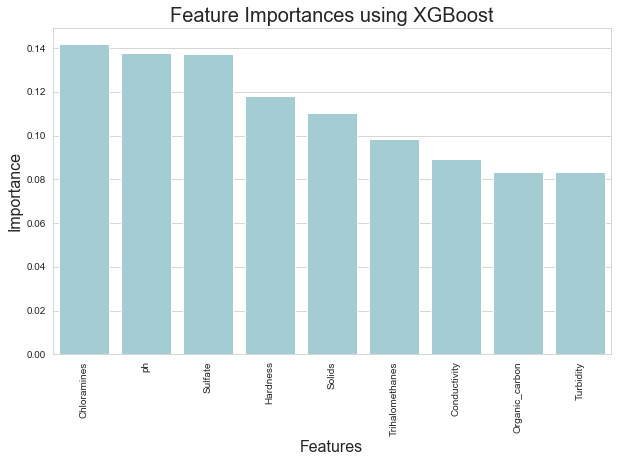

In [50]:
# create a mapping of features and feature importance
imp_features_xgb = pd.DataFrame(
    {
        'features': x.columns,
        'importance': model.feature_importances_
    }
)

# sort the features by their feature importance in descending order
imp_features_xgb = imp_features_xgb.sort_values(by='importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10,6))

ax = sns.barplot(x='features', y='importance', data=imp_features_xgb, color='#9cd3db')

plt.title('Feature Importances using XGBoost',  size=20)
plt.xlabel('Features', size=16)
plt.ylabel('Importance', size=16)
plt.xticks(rotation='vertical')

plt.show()

In [32]:
# analyze & handle null values of ph column
# describe the column
display(df['ph'].describe())

# all values within ph scale(0 - 14), hence no outliers
# replace null values with column mean
df['ph'] = df['ph'].fillna(value=df['ph'].mean())

# verify the null value count
print("null counts:", df['ph'].isna().sum())

count    2785.000000
mean        7.080795
std         1.594320
min         0.000000
25%         6.093092
50%         7.036752
75%         8.062066
max        14.000000
Name: ph, dtype: float64

null counts: 0


In [33]:
# analyze & handle null values of Sulfate column
# describe the column
display(df['Sulfate'].describe())

# both the mean and median values of the Sulfate column are similar
# hence, either can be used to replace null values
df['Sulfate'] = df['Sulfate'].fillna(value=df['Sulfate'].median())

# verify the null value count
print("null counts:", df['Sulfate'].isna().sum())

count    2495.000000
mean      333.775777
std        41.416840
min       129.000000
25%       307.699498
50%       333.073546
75%       359.950170
max       481.030642
Name: Sulfate, dtype: float64

null counts: 0


In [34]:
# analyze & handle null values of Trihalomethanes column
# describe the column
display(df['Trihalomethanes'].describe())

# both the mean and median values of the Sulfate column are similar
# hence, either can be used to replace null values
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median())

# verify the null value count
print("null counts:", df['Trihalomethanes'].isna().sum())

count    3114.000000
mean       66.396293
std        16.175008
min         0.738000
25%        55.844536
50%        66.622485
75%        77.337473
max       124.000000
Name: Trihalomethanes, dtype: float64

null counts: 0


In [35]:
# verify null value(NaN) counts for each column
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

0    1998
1    1278
Name: Potability, dtype: int64


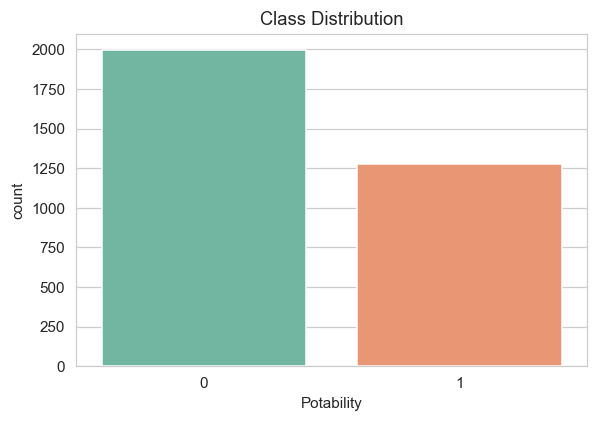

In [36]:
# class distribution
print(df['Potability'].value_counts())

# plot the class distribution
plt.figure(dpi=110)
chart = sns.countplot(x="Potability", data=df, palette="Set2")
axes = chart.axes
axes.set_title('Class Distribution')
axes.set_xlabel('Potability')
plt.show()

## Univariate Analysis:
---


   - ### ph-

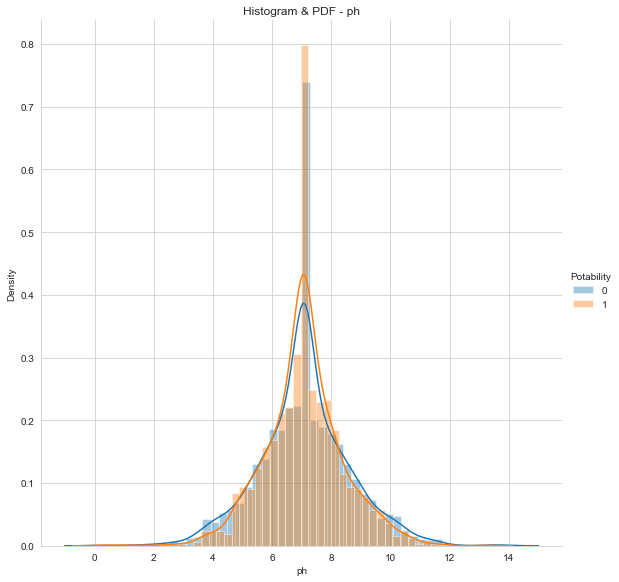

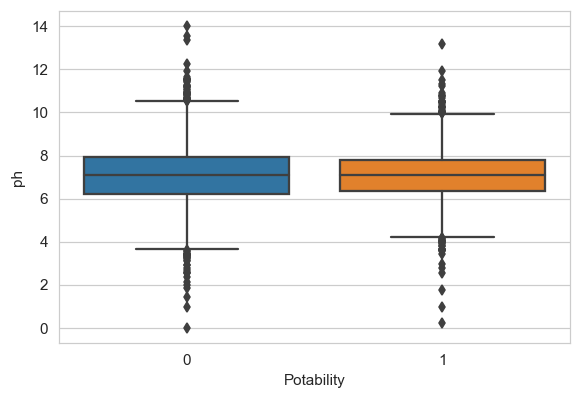

In [12]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'ph').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - ph')
axes[0].set_xlabel('ph')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='ph', data=df)
plt.show()

   - ### Hardness-

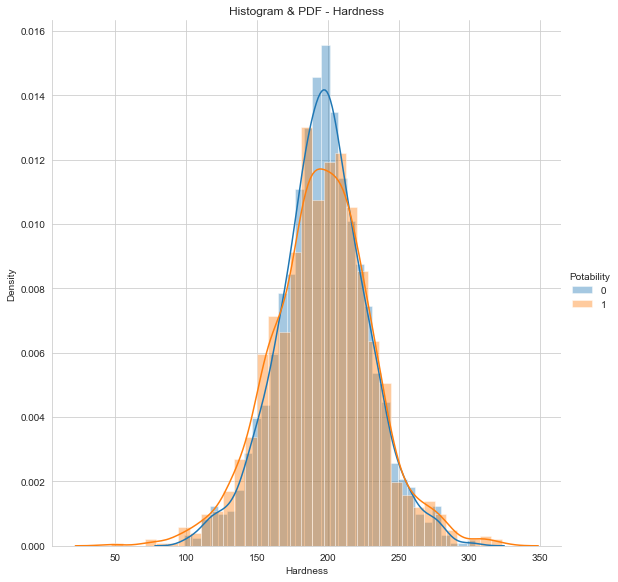

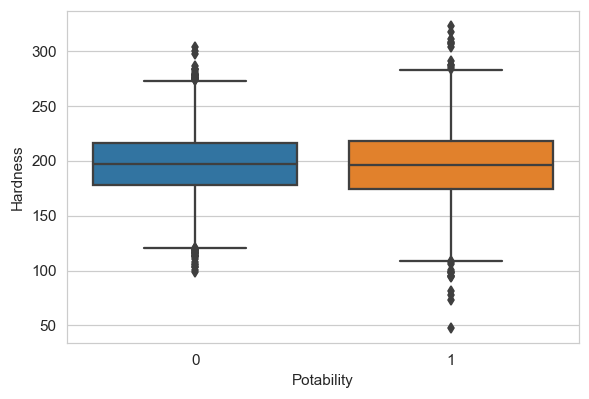

In [13]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Hardness').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Hardness')
axes[0].set_xlabel('Hardness')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Hardness', data=df)
plt.show()

   - ### Solids-

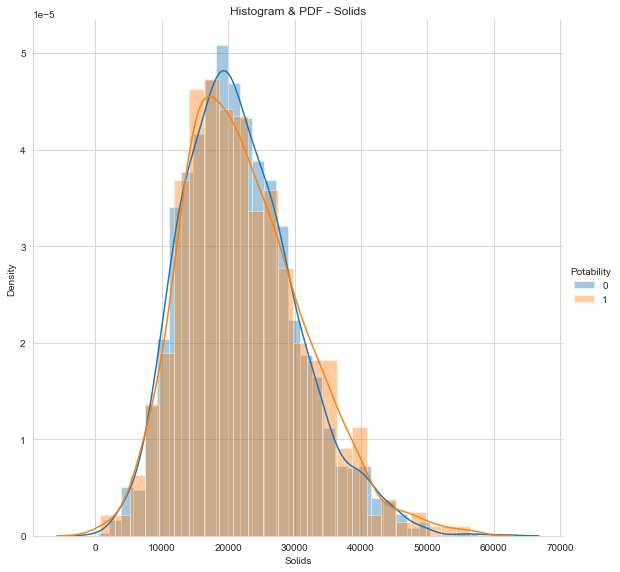

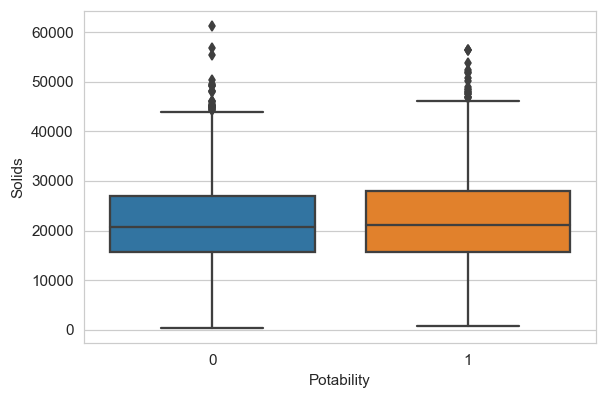

In [14]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Solids').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Solids')
axes[0].set_xlabel('Solids')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Solids', data=df)
plt.show()

   - ### Chloramines-

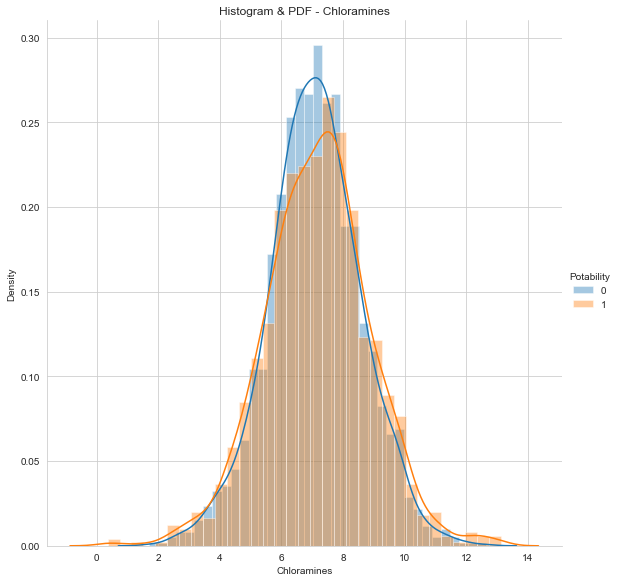

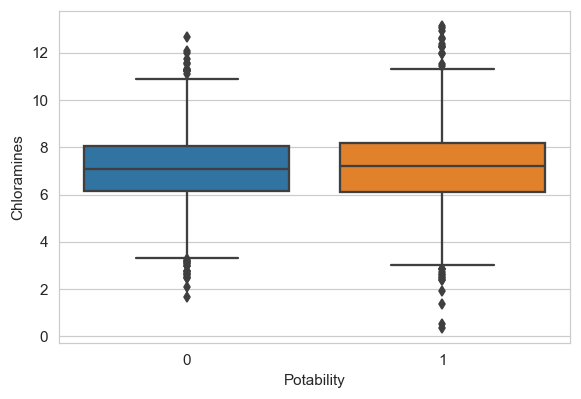

In [15]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Chloramines').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Chloramines')
axes[0].set_xlabel('Chloramines')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Chloramines', data=df)
plt.show()

   - ### Sulfate-

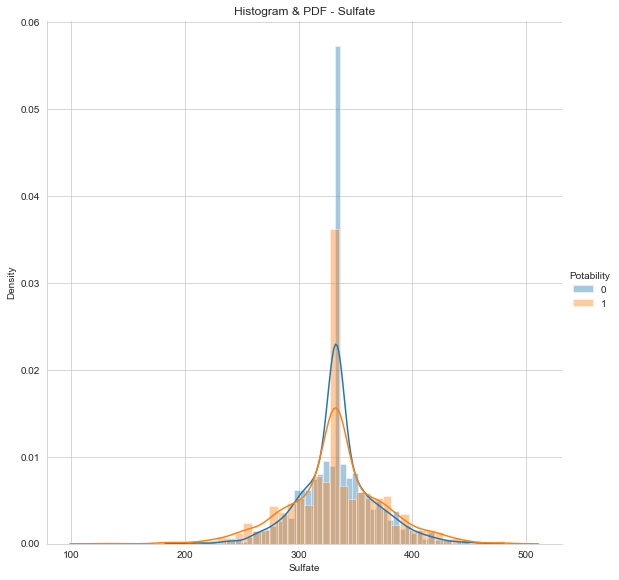

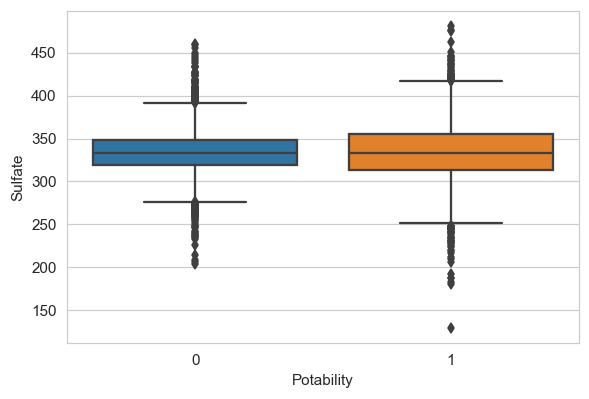

In [16]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Sulfate').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Sulfate')
axes[0].set_xlabel('Sulfate')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Sulfate', data=df)
plt.show()

   - ### Conductivity-

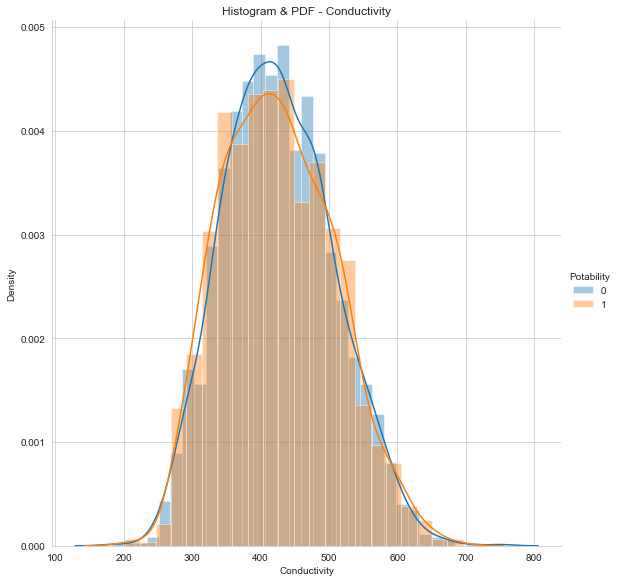

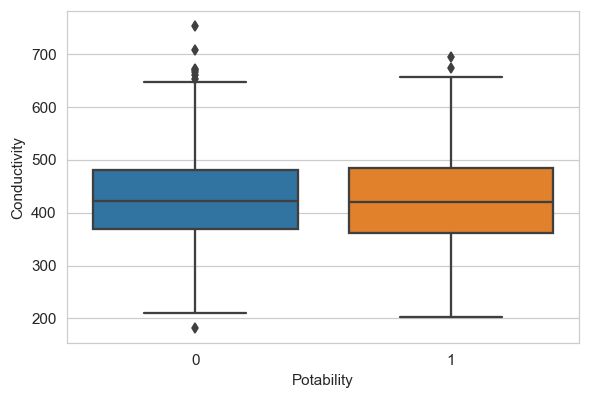

In [17]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Conductivity').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Conductivity')
axes[0].set_xlabel('Conductivity')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Conductivity', data=df)
plt.show()

   - ### Organic Carbon-

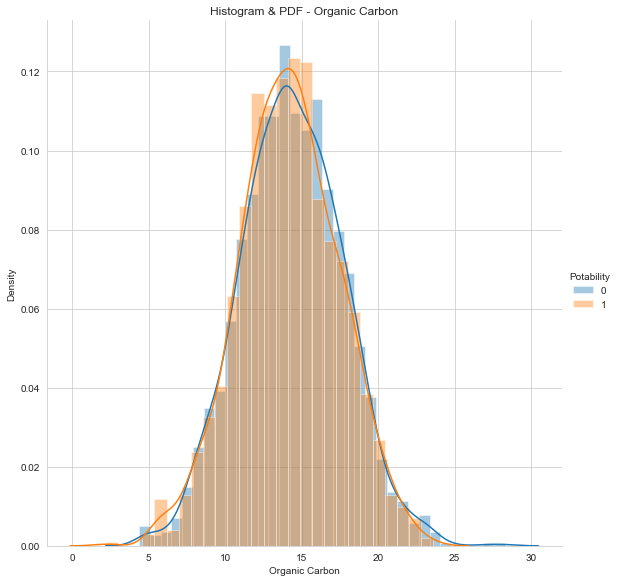

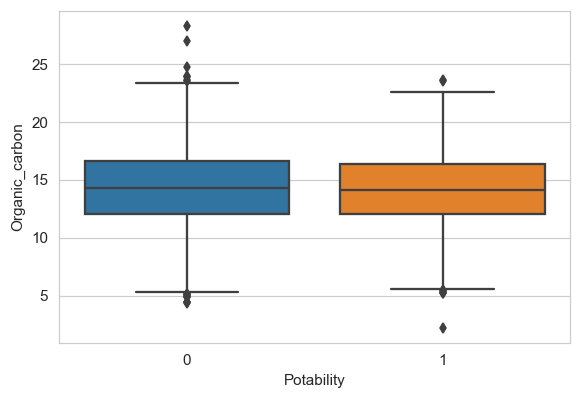

In [18]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Organic_carbon').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Organic Carbon')
axes[0].set_xlabel('Organic Carbon')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Organic_carbon', data=df)
plt.show()

   - ### Trihalomethanes-

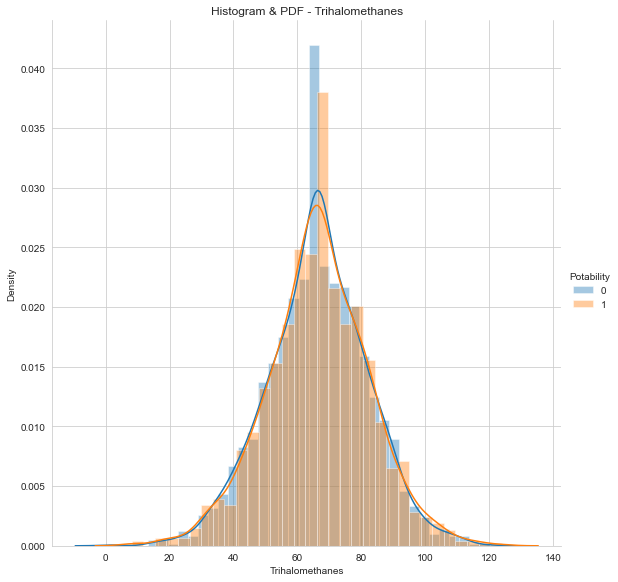

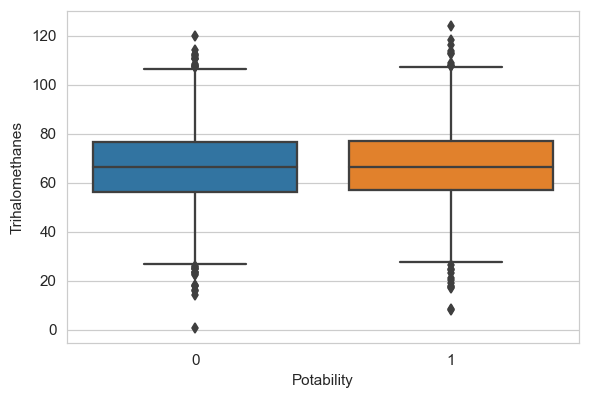

In [19]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Trihalomethanes').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Trihalomethanes')
axes[0].set_xlabel('Trihalomethanes')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Trihalomethanes', data=df)
plt.show()

   - ### Turbidity-

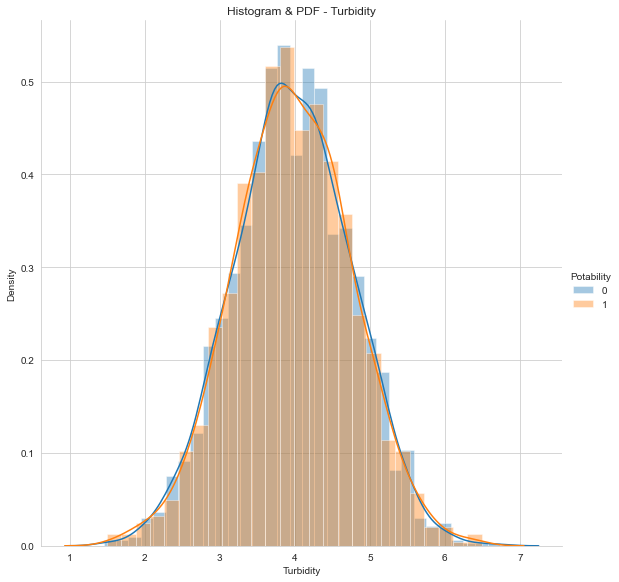

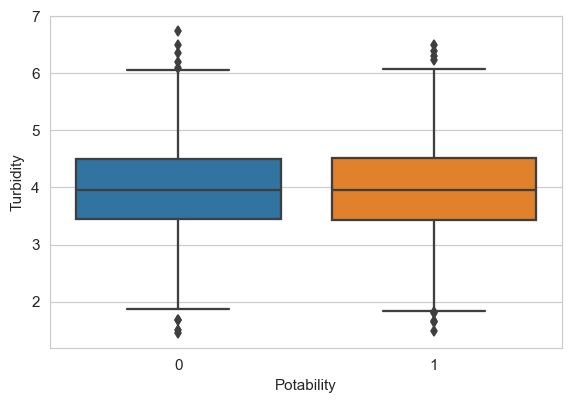

In [20]:
chart = sns.FacetGrid(df, hue='Potability', height=8).map(sns.distplot, 'Turbidity').add_legend()
axes = chart.axes.flatten()
axes[0].set_title('Histogram & PDF - Turbidity')
axes[0].set_xlabel('Turbidity')
plt.show()

plt.figure(dpi=110)
sns.boxplot(x='Potability', y='Turbidity', data=df)
plt.show()

### Observation:
- There is complete overlap between the class labels for each feature, which makes either of the features useless individually.
- A combination of some or all the features will be required to solve the problem.

## Bivariate Analysis:

---

- ### Pair Plot:

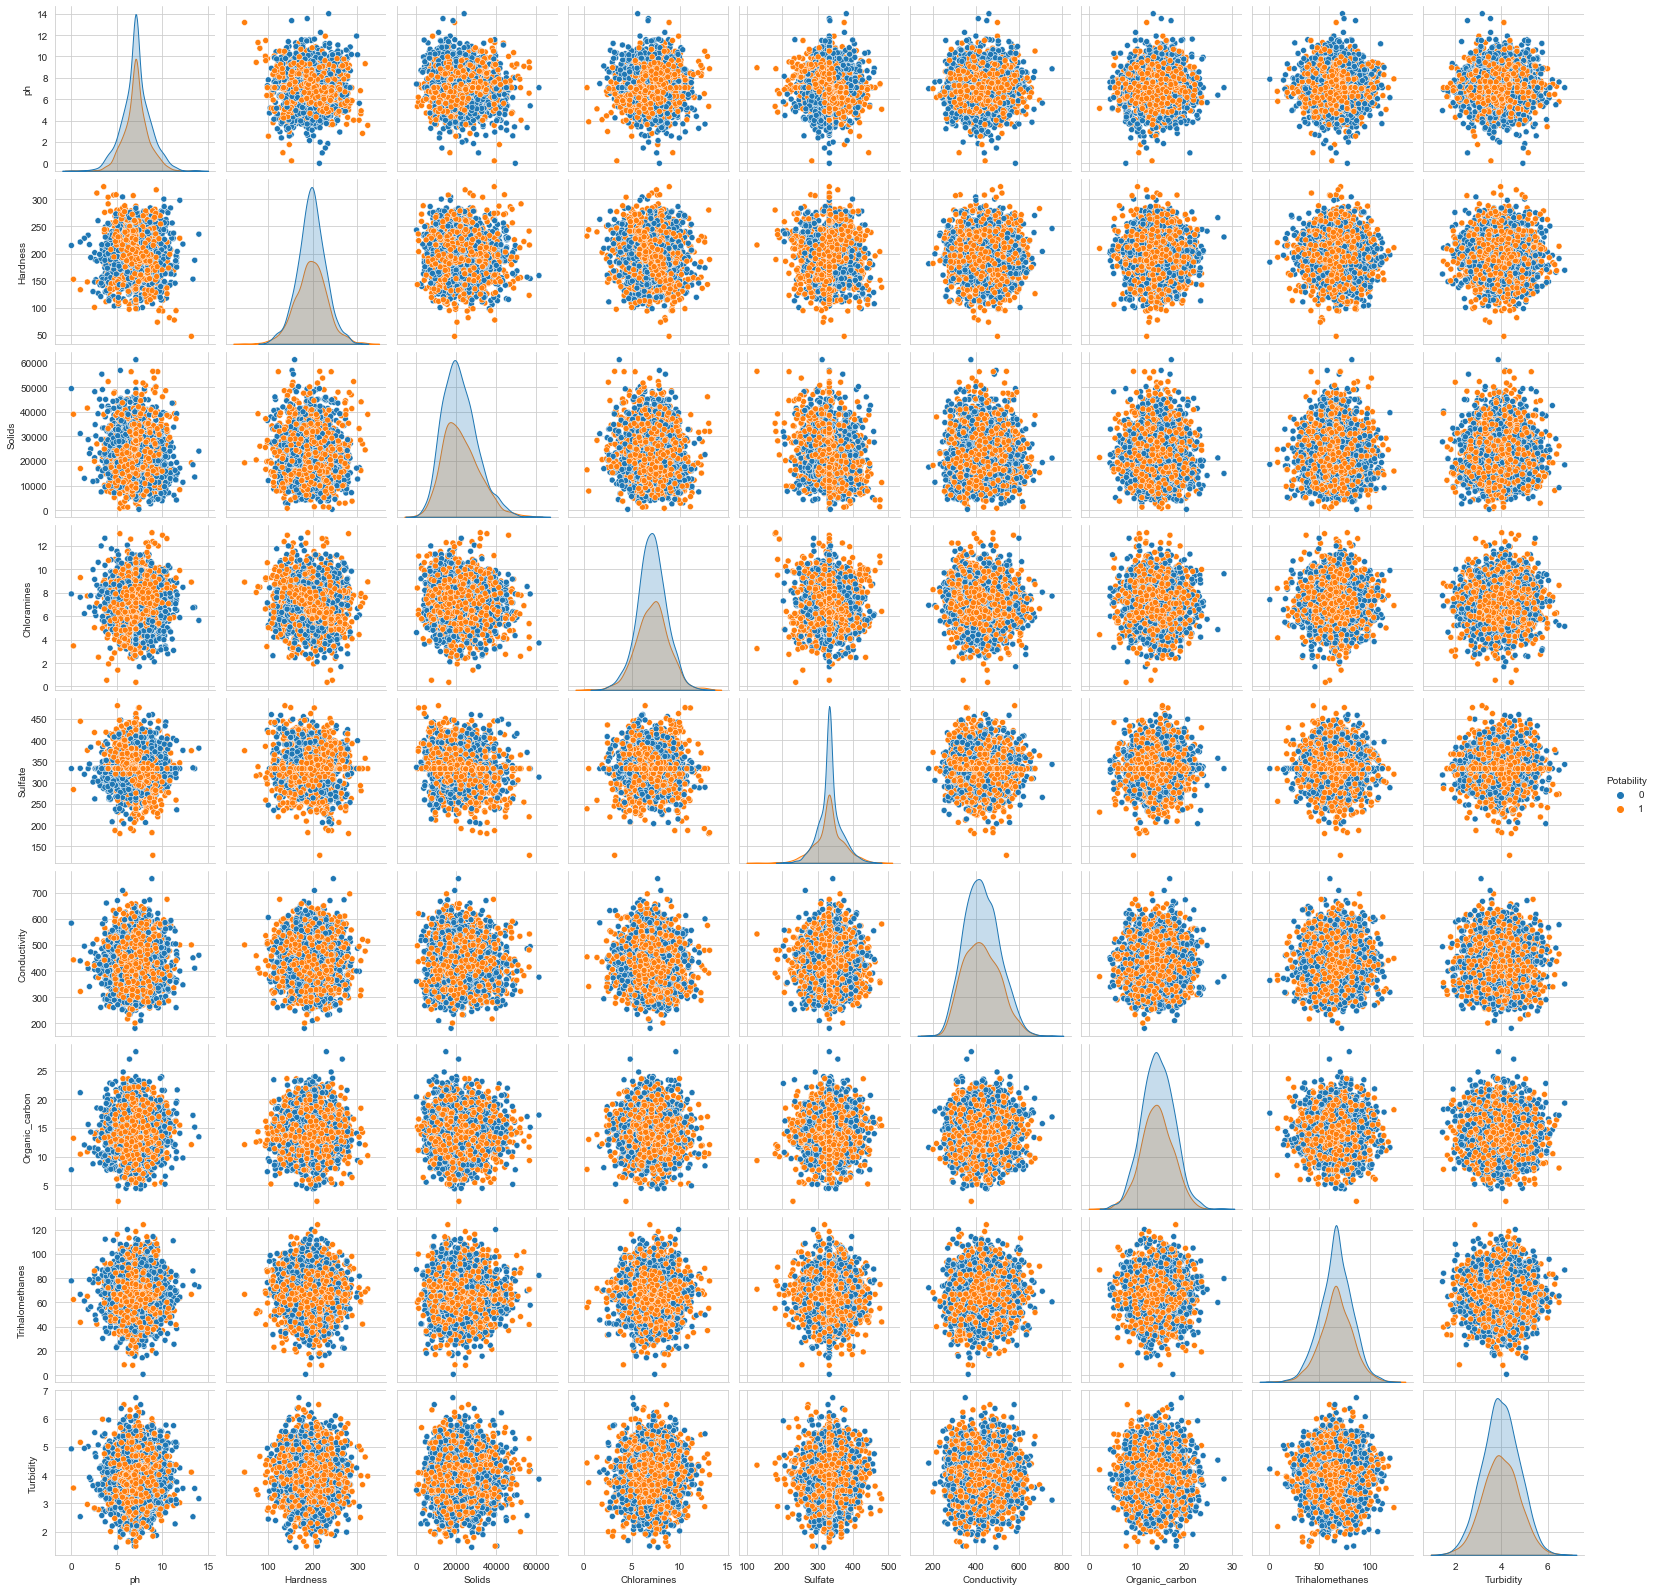

In [21]:
sns.pairplot(df, hue="Potability")
plt.show()

- ### HeatMap Plot:
    - ### Attribute Correlation-

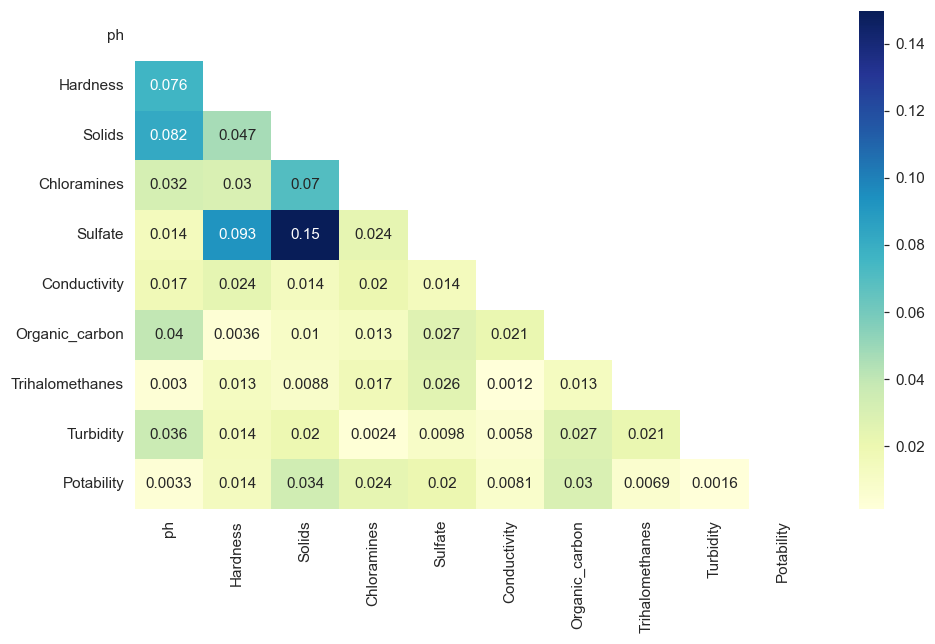

In [22]:
# mask for heatmap
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

# plot feature correlations
plt.figure(figsize=(10,6), dpi=110)
sns.heatmap(df.corr().abs(), annot=True, cmap="YlGnBu", mask=mask)
plt.show()

### Observation: 
- No significant correlation between any of the columns, hence there are no redundant features that can be dropped.
- The highest correlation is 15%(approx) that exists between the features: **Solids** & **Sulfate**.
- Other pairs of features with considerable correlation are:
    - **ph** & **Hardness**
    - **ph** & **Solids**
    - **Hardness** & **Sulfate**
    - **Solids** & **Chloramines**

- ### Scatter Plot:
    - ### Solids vs Sulfate-

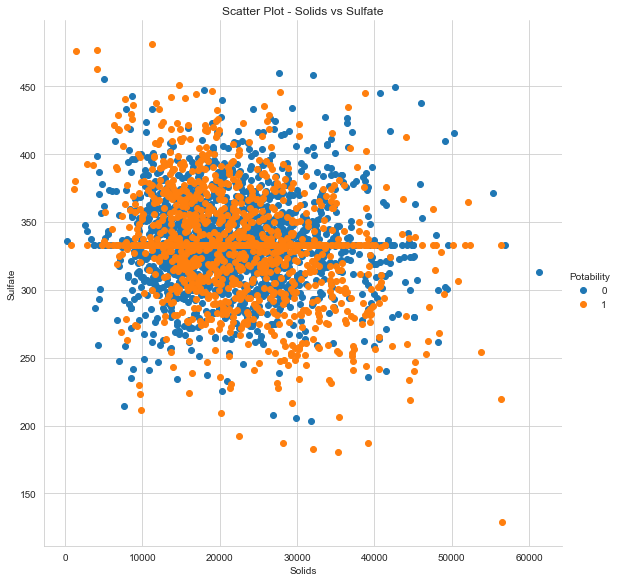

In [23]:
chart = sns.FacetGrid(df, hue="Potability", height=8).map(plt.scatter, "Solids", "Sulfate").add_legend()
axes = chart.axes.flatten()
axes[0].set_title("Scatter Plot - Solids vs Sulfate")
axes[0].set_xlabel("Solids")
axes[0].set_ylabel("Sulfate")
plt.show()

### Observation:
- The pair of features with the maximum correlation are unable to separate the datapoints clearly in 2D.

## Multivariate Analysis:

---

- ### 3D Scatter Plot:
    - ### Solids vs Sulfate vs Potability-

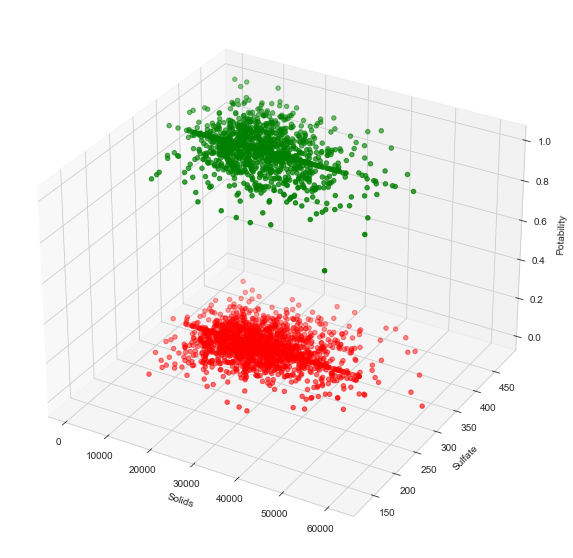

In [24]:
# plot 3d scatter plot
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
color = ['r' if x==0 else 'g' for x in df['Potability']]
ax.scatter(df['Solids'], df['Sulfate'], df['Potability'], c=color)
ax.set_xlabel('Solids')
ax.set_ylabel('Sulfate')
ax.set_zlabel('Potability')
plt.show()

In [12]:
# train-validation-test split (60-20-20)
# train-test split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Potability'], random_state=42)

# train-validation
df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train['Potability'], random_state=42)

# rest index
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# size of train-validation-test sets
print('train:',df_train.shape[0])
print('valid:',df_valid.shape[0])
print('test:',df_test.shape[0])

# save train set
df_train.to_csv('../data/train_data.csv', index=False)

# save validation set
df_valid.to_csv('../data/valid_data.csv', index=False)

# save test set
df_test.to_csv('../data/test_data.csv', index=False)

train: 1965
valid: 655
test: 656
